In [1]:
import fsspec

fs = fsspec.filesystem('gs')
fs.ls('gs://gcp-public-data-arco-era5/co/')

['gcp-public-data-arco-era5/co/model-level-moisture.zarr',
 'gcp-public-data-arco-era5/co/model-level-moisture.zarr-v2',
 'gcp-public-data-arco-era5/co/model-level-wind.zarr',
 'gcp-public-data-arco-era5/co/model-level-wind.zarr-v2',
 'gcp-public-data-arco-era5/co/single-level-forecast.zarr',
 'gcp-public-data-arco-era5/co/single-level-forecast.zarr-v2',
 'gcp-public-data-arco-era5/co/single-level-reanalysis.zarr',
 'gcp-public-data-arco-era5/co/single-level-reanalysis.zarr-v2',
 'gcp-public-data-arco-era5/co/single-level-surface.zarr',
 'gcp-public-data-arco-era5/co/single-level-surface.zarr-v2']

In [127]:
import xarray

ds = xarray.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks={'time': 48},
    storage_options=dict(token='anon'),
)["2m_temperature"].sel(time=slice('1990-01-01', '2024-11-01'))

ds_for = xarray.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks={'time': 48},
    storage_options=dict(token='anon'),
)["maximum_2m_temperature_since_previous_post_processing"].sel(time=slice('1990-01-01', '2024-11-01'))

print(ds_for)

<xarray.DataArray 'maximum_2m_temperature_since_previous_post_processing' (
                                                                           time: 305376,
                                                                           latitude: 721,
                                                                           longitude: 1440)>
dask.array<getitem, shape=(305376, 721, 1440), dtype=float32, chunksize=(48, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1990-01-01 ... 2024-11-01T23:00:00
Attributes:
    long_name:   Maximum temperature at 2 metres since previous post-processing
    short_name:  mx2t
    units:       K


In [113]:
def lon_to_360(dlon: float) -> float:
  return ((360 + (dlon % 360)) % 360)

champaign_coords = {"min_lat": 40.07651334790849, "max_lat": 40.3265133, "min_long": lon_to_360(-88.38088352464067), "max_long": lon_to_360(-88.0608835)}

champaign_ds = ds.where(
    (ds.longitude > champaign_coords["min_long"]) & (ds.latitude > champaign_coords["min_lat"]) &
    (ds.longitude < champaign_coords["max_long"]) & (ds.latitude < champaign_coords["max_lat"]),
    drop=True
)

champaign_spatially_expanded_ds = ds.where (
    (ds.longitude > champaign_coords["min_long"] - 0.25) & (ds.latitude > champaign_coords["min_lat"] - 0.25) &
    (ds.longitude < champaign_coords["max_long"] + 0.25) & (ds.latitude < champaign_coords["max_lat"] + 0.25),
    drop=True
)

champaign_ds_for = ds_for.where(
    (ds_for.longitude > champaign_coords["min_long"]) & (ds_for.latitude > champaign_coords["min_lat"]) &
    (ds_for.longitude < champaign_coords["max_long"]) & (ds_for.latitude < champaign_coords["max_lat"]),
    drop=True
)

champaign_spatially_expanded_ds_for = ds_for.where (
    (ds_for.longitude > champaign_coords["min_long"] - 0.25) & (ds_for.latitude > champaign_coords["min_lat"] - 0.25) &
    (ds_for.longitude < champaign_coords["max_long"] + 0.25) & (ds_for.latitude < champaign_coords["max_lat"] + 0.25),
    drop=True
)

champaign_ds_for

<xarray.DataArray 'maximum_2m_temperature_since_previous_post_processing' (
                                                                           time: 305376,
                                                                           latitude: 1,
                                                                           longitude: 1)>
dask.array<where, shape=(305376, 1, 1), dtype=float32, chunksize=(48, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 40.25
  * longitude  (longitude) float32 271.8
  * time       (time) datetime64[ns] 1990-01-01 ... 2024-11-01T23:00:00
Attributes:
    long_name:   Maximum temperature at 2 metres since previous post-processing
    short_name:  mx2t
    units:       K

In [101]:
import numpy as np
import pandas as pd

def grid_point_analysis(ds, lat, long, date):
    today_temp = ds.sel(time=date, latitude = lat, longitude = long).values
    
    historical_data = ds.sel(time=ds.time.dt.dayofyear.isin(range(date.dayofyear - 10, date.dayofyear + 11)))
    hist_values = historical_data.values.flatten()

    if today_temp < np.percentile(hist_values, 5):
        return 'Extremely Low'
    elif today_temp > np.percentile(hist_values, 95):
        return 'Extremely High'
    else:
        return 'Normal'

In [107]:
date = pd.Timestamp('1999-01-05')
champaign_lat = 40.25
champaign_long = 271.75
result = grid_point_analysis(champaign_ds, champaign_lat, champaign_long, date)
result_spatial_expand = grid_point_analysis(champaign_spatially_expanded_ds, champaign_lat, champaign_long, date)

print(f"Classification of temperature on {date.strftime("%Y-%m-%d")} is: ", result)
print(f"Classification of temperature on {date.strftime("%Y-%m-%d")} spacially expanded is: ", result_spatial_expand)

Classification of temperature on <built-in method date of Timestamp object at 0x7fb1ef99ebc0> is:  Extremely Low
Classification of temperature on <built-in method date of Timestamp object at 0x7fb1ef99ebc0> spacially expanded is:  Extremely Low


In [109]:
from flox.xarray import xarray_reduce
import numpy as np

def grid_point_analysis_time_expanded(ds, lat, long, date):
    ds_ten = ds.sel(time=ds.time.dt.dayofyear.isin(range(date.dayofyear - 10, date.dayofyear + 11)))
    ds_week = ds.sel(time=ds.time.dt.isocalendar().week == date.isocalendar().week)
    ds_month = ds.sel(time=ds.time.dt.month == date.month)

    ten_avg = xarray_reduce(
        ds_ten,
        ds_ten.time.dt.year,
        func='mean',
        dim=["time"],
        engine='flox'
    ).values.flatten()

    weekly_avg = xarray_reduce(
        ds_week,
        ds_week.time.dt.year,
        func='mean',
        dim=["time"],
        engine='flox'
    ).values.flatten()

    monthly_avg = xarray_reduce(
        ds_month,
        ds_month.time.dt.year,
        func='mean',
        dim=["time"],
        engine='flox'
    ).values.flatten()

    percentiles_ten = np.percentile(ten_avg, [5, 50, 95])
    percentiles_week = np.percentile(weekly_avg, [5, 50, 95])
    percentiles_month = np.percentile(monthly_avg, [5, 50, 95])

    # Determine classification for each time frame
    def classify_temp(today_temp, percentiles):
        if today_temp < percentiles[0]:
            return 'Extreme Low'
        elif today_temp > percentiles[2]:
            return 'Extreme High'
        else:
            return 'Normal'

    today_temp = ds.sel(time=date, latitude = lat, longitude = long).values
    
    classification_ten = classify_temp(today_temp, percentiles_ten)
    classification_week = classify_temp(today_temp, percentiles_week)
    classification_month = classify_temp(today_temp, percentiles_month)

    return {
        'today_temp': today_temp,
        'percentiles_ten': percentiles_ten,
        'classification_ten': classification_ten,
        'percentiles_week': percentiles_week,
        'classification_week': classification_week,
        'percentiles_month': percentiles_month,
        'classification_month': classification_month,
    }

In [112]:
date = pd.Timestamp('1999-01-05')
champaign_lat = 40.25
champaign_long = 271.75
result_time = grid_point_analysis_time_expanded(champaign_ds, champaign_lat, champaign_long, date)
result_time_spatial_expand = grid_point_analysis_time_expanded(champaign_spatially_expanded_ds, champaign_lat, champaign_long, date)

print(f'Classification of temperature on {date.strftime("%Y-%m-%d")} time expanded is: ')
print(f'\t{result_time["classification_ten"]} in +- 10 day timeframe')
print(f'\t{result_time["classification_ten"]} in Week timeframe')
print(f'\t{result_time["classification_ten"]} in Month timeframe')

print(f'Classification of temperature on {date.strftime("%Y-%m-%d")} time and spacially expanded is: ')
print(f'\t{result_time["classification_ten"]} in +- 10 day timeframe')
print(f'\t{result_time["classification_ten"]} in Week timeframe')
print(f'\t{result_time["classification_ten"]} in Month timeframe')

Classification of temperature on 1999-01-05 time expanded is: 
	Extreme Low in +- 10 day timeframe
	Extreme Low in week timeframe
	Extreme Low in month timeframe
Classification of temperature on 1999-01-05 time and spacially expanded is:  {'today_temp': array(251.70203, dtype=float32), 'percentiles_ten': array([263.65694885, 271.07077026, 276.59189758]), 'classification_ten': 'Extreme Low', 'percentiles_week': array([259.68166809, 272.24557495, 279.33952637]), 'classification_week': 'Extreme Low', 'percentiles_month': array([266.7875885 , 270.39959717, 275.5693512 ]), 'classification_month': 'Extreme Low'}
	Extreme Low in +- 10 day timeframe
	Extreme Low in week timeframe
	Extreme Low in month timeframe


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


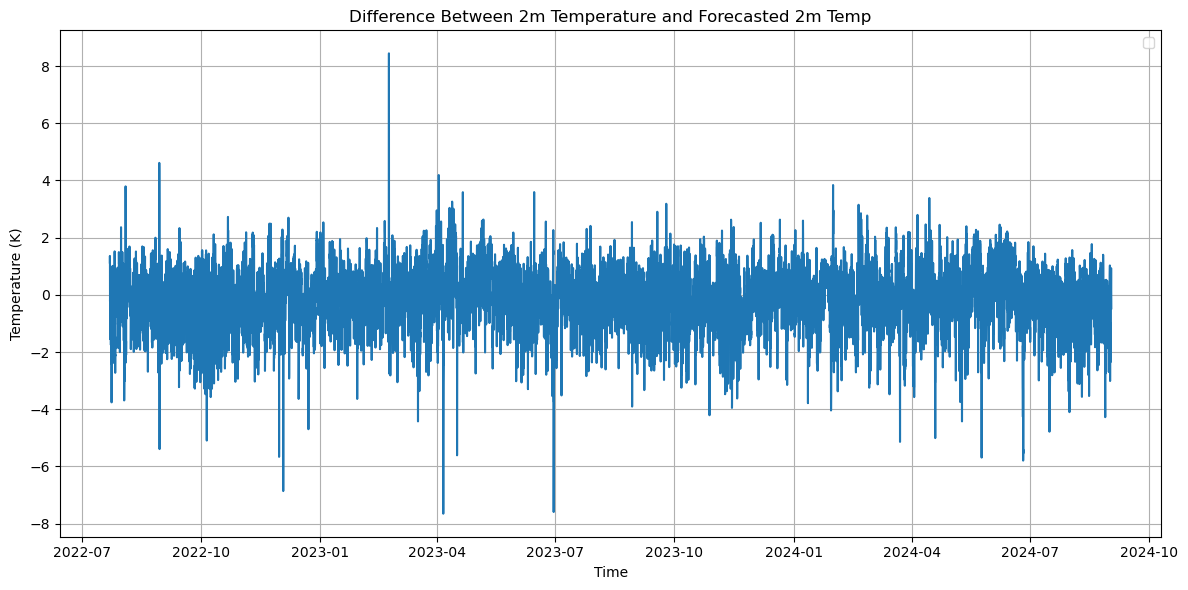

In [125]:
import matplotlib.pyplot as plt
import pandas as pd

ana = champaign_ds.isel(time=slice(-20000, None)).to_dataframe().reset_index()
fore = champaign_ds_for.isel(time=slice(-20000, None)).to_dataframe().reset_index()

diff = pd.DataFrame()
diff['Diff'] = ana['2m_temperature'] - fore['maximum_2m_temperature_since_previous_post_processing']

plt.figure(figsize=(12, 6))
# plt.plot(ana['time'], ana['2m_temperature'], label="2m Temperature", color='blue')
# plt.plot(fore['time'], fore['maximum_2m_temperature_since_previous_post_processing'], 
#          label="Max 2m Temp (since last processing)", color='red', alpha=0.7)
plt.plot(ana['time'], diff['Diff'])

# Add labels, legend, and title
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Difference Between 2m Temperature and Forecasted 2m Temp')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [131]:
difference = champaign_ds.values - champaign_ds_for.values

# Create a mask for positive and negative differences
positive_diff = difference[difference > 0]  # Keep only positive differences
negative_diff = difference[difference < 0]  # Keep only negative differences

print(len(positive_diff))
print(len(negative_diff))



140337
163569


In [ ]:
extreme_diff_threshold = np.percentile(negative_diff, 5)

champaign_df = champaign_ds.to_dataframe().reset_index()
champaign_for_df = champaign_ds_for.to_dataframe().reset_index()


extreme_negative_mask = (champaign_df['2m_temperature'] - champaign_for_df['maximum_2m_temperature_since_previous_post_processing']) < extreme_diff_threshold
extreme_negative_actuals_df = champaign_df[extreme_negative_mask]


In [151]:
extreme_negative_actuals_df['diff'] = extreme_negative_actuals_df['2m_temperature'] - champaign_for_df['maximum_2m_temperature_since_previous_post_processing']
extreme_negative_actuals_df

/tmp/ipykernel_78281/1713287344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_negative_actuals_df['diff'] = extreme_negative_actuals_df['2m_temperature'] - champaign_for_df['maximum_2m_temperature_since_previous_post_processing']


,time,latitude,longitude,2m_temperature,diff
46,1990-01-02 22:00:00,40.25,271.75,276.198303,-2.724762
89,1990-01-04 17:00:00,40.25,271.75,277.718201,-3.747650
90,1990-01-04 18:00:00,40.25,271.75,275.598755,-2.789948
94,1990-01-04 22:00:00,40.25,271.75,273.399902,-2.589172
118,1990-01-05 22:00:00,40.25,271.75,272.661682,-3.511353
...,...,...,...,...,...
303808,2024-08-28 16:00:00,40.25,271.75,297.934174,-2.744537
303810,2024-08-28 18:00:00,40.25,271.75,299.844849,-2.551849
303811,2024-08-28 19:00:00,40.25,271.75,299.542999,-2.601471
303864,2024-08-31 00:00:00,40.25,271.75,298.747772,-2.698608


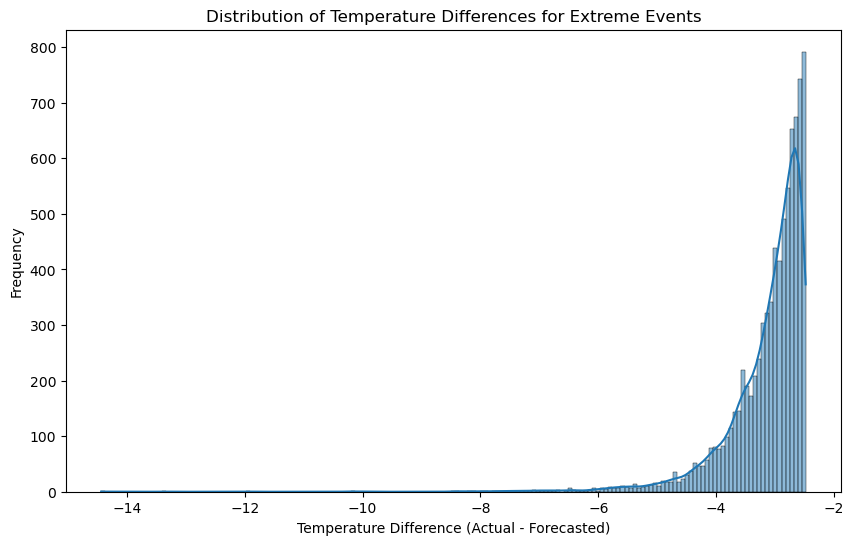

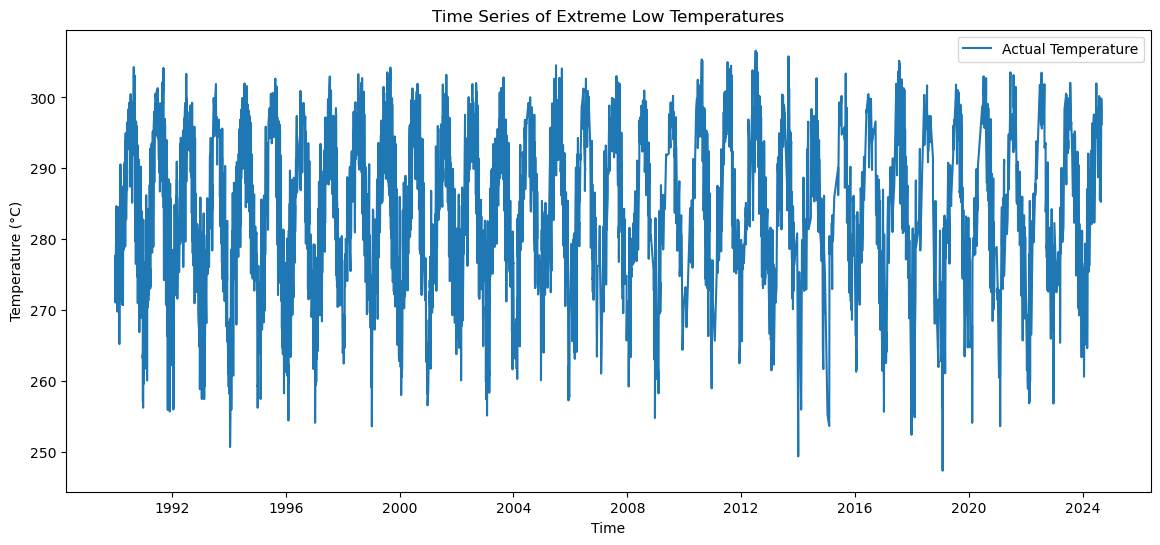

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of temperature differences
plt.figure(figsize=(10, 6))
sns.histplot(extreme_negative_actuals_df['2m_temperature'] - champaign_for_df['maximum_2m_temperature_since_previous_post_processing'], kde=True)
plt.title('Distribution of Temperature Differences for Extreme Events')
plt.xlabel('Temperature Difference (Actual - Forecasted)')
plt.ylabel('Frequency')
plt.show()

# Time series plot of extreme temperatures
plt.figure(figsize=(14, 6))
plt.plot(extreme_negative_actuals_df['time'], extreme_negative_actuals_df['2m_temperature'], label='Actual Temperature')
plt.title('Time Series of Extreme Low Temperatures')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


In [152]:
extreme_negative_actuals_df.nsmallest(10, 'diff')

,time,latitude,longitude,2m_temperature,diff
158471,2008-01-29 23:00:00,40.25,271.75,268.029633,-14.436798
106816,2002-03-09 16:00:00,40.25,271.75,272.775116,-13.353058
53014,1996-01-18 22:00:00,40.25,271.75,266.501312,-11.938049
62612,1997-02-21 20:00:00,40.25,271.75,277.041779,-10.178406
62611,1997-02-21 19:00:00,40.25,271.75,278.012482,-10.166290
134639,2005-05-11 23:00:00,40.25,271.75,292.074371,-8.444916
62613,1997-02-21 21:00:00,40.25,271.75,276.251282,-8.403412
19181,1992-03-10 05:00:00,40.25,271.75,276.110291,-8.391235
281780,2022-02-22 20:00:00,40.25,271.75,279.808167,-8.156555
647,1990-01-27 23:00:00,40.25,271.75,276.278687,-8.122681


In [154]:
date = pd.Timestamp('2008-01-29')
datestr = date.strftime("%Y-%m-%d")
champaign_lat2 = 40.25
champaign_long2 = 271.75
result = grid_point_analysis(champaign_ds, champaign_lat2, champaign_long2, date)
result_spatial_expand = grid_point_analysis(champaign_spatially_expanded_ds, champaign_lat, champaign_long, date)

print(f"Classification of temperature on {datestr} is: ", result)
print(f"Classification of temperature on {datestr} spacially expanded is: ", result_spatial_expand)

Classification of temperature on 2008-01-29 is:  Normal
Classification of temperature on 2008-01-29 spacially expanded is:  Normal


In [ ]:
extreme_lows = 0
for timestamp in extreme_negative_actuals_df.nsmallest(100, 'diff')['time']:
    if grid_point_analysis(champaign_ds, champaign_lat2, champaign_long2, timestamp) == "Extremely Low":
        extreme_lows += 1

In [160]:
print(extreme_lows)

1
